In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/InsNova_data_2023_train.csv')
df.drop(['id'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,...,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
0,0.77,0.444504,SEDAN,4,M,D,3,petrol,147,67.0,...,S,1,weekday,6pm - 12am,6,640.448137,1.0,0,0,0.0
1,4.45,0.562183,STNWG,1,M,A,3,petrol,158,76.0,...,S,1,weekday,6am - 12pm,12,683.749691,0.0,0,0,0.0
2,4.90,0.465244,STNWG,1,F,A,3,petrol,159,58.0,...,M,1,weekday,6pm - 12am,6,653.656117,1.0,0,0,0.0
3,0.48,0.271039,PANVN,4,M,A,4,petrol,80,72.0,...,S,1,weekday,12pm - 6pm,12,642.574671,0.0,0,0,0.0
4,0.85,0.141624,SEDAN,4,F,A,5,petrol,126,91.0,...,S,0,weekday,6am - 12pm,6,647.175035,0.0,0,0,0.0


In [3]:
df_dummies = pd.get_dummies(df, columns=['veh_body', 'veh_age', 'gender', 'area', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind'])

In [4]:
cost_df = df_dummies.drop(columns=['clm', 'numclaims'])

In [5]:
majority_class = cost_df[cost_df['claimcst0'] == 0]
minority_class = cost_df[cost_df['claimcst0'] != 0]

print(majority_class.shape)
print(minority_class.shape)

(21077, 64)
(1542, 64)


In [6]:
oversampled_minority = resample(minority_class, replace=True, n_samples=5 * len(majority_class))

oversampled_minority.shape

(105385, 64)

In [7]:
cost_balanced_df = pd.concat([majority_class, oversampled_minority])
# cost_balanced_df = pd.concat([majority_class, minority_class])
cost_balanced_df = cost_balanced_df.sample(frac=1)
cost_balanced_df.reset_index(drop=True, inplace=True)

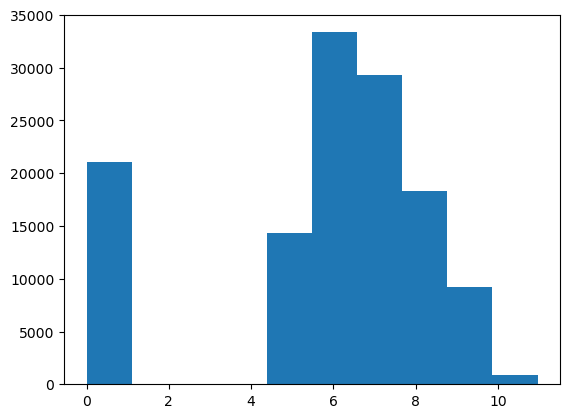

In [8]:
plt.hist(np.log(cost_balanced_df['claimcst0'] + 1))
plt.show()

In [9]:
cost_x, cost_y = cost_balanced_df.drop(columns=['claimcst0']), cost_balanced_df['claimcst0']
cost_y = np.log(cost_y + 1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(cost_x, cost_y, test_size=1 / 3)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(84308, 63) (84308,) (42154, 63) (42154,)


In [11]:
all_combos = []

for n_neighbors in [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 41, 51, 61, 71, 81, 91, 101, 125]:
    for weights in ['uniform', 'distance']:
        all_combos.append((n_neighbors, weights))

percentage_to_try = 1.0
n_runs = int(percentage_to_try * len(all_combos))
combos_to_try = random.sample(all_combos, n_runs)
print(f'Num runs: {n_runs}')

best_validation_loss, cost_model = np.inf, None

for n_neighbors, weights in combos_to_try:
    curr_model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    curr_model.fit(x_train, y_train)

    pred = curr_model.predict(x_test)
    # validation_loss = mean_squared_log_error(y_test, pred)
    validation_loss = mean_squared_error(y_test, pred)

    if validation_loss < best_validation_loss:
        best_validation_loss, cost_model = validation_loss, curr_model
        print(f'Best loss so far: {best_validation_loss}')

    n_runs -= 1
    print(f'Remaining runs: {n_runs}')
    

Num runs: 46
Best loss so far: 3.1687609743126264
Remaining runs: 45
Remaining runs: 44
Best loss so far: 1.9325058382532774
Remaining runs: 43
Remaining runs: 42
Remaining runs: 41
Remaining runs: 40
Remaining runs: 39
Remaining runs: 38
Remaining runs: 37
Remaining runs: 36
Best loss so far: 1.116180667125258
Remaining runs: 35
Remaining runs: 34
Remaining runs: 33
Remaining runs: 32
Remaining runs: 31
Remaining runs: 30
Remaining runs: 29
Remaining runs: 28
Remaining runs: 27
Remaining runs: 26
Remaining runs: 25
Remaining runs: 24
Remaining runs: 23
Remaining runs: 22
Remaining runs: 21
Remaining runs: 20
Remaining runs: 19
Remaining runs: 18
Remaining runs: 17
Remaining runs: 16
Remaining runs: 15
Remaining runs: 14
Remaining runs: 13
Remaining runs: 12
Remaining runs: 11
Remaining runs: 10
Remaining runs: 9
Remaining runs: 8
Remaining runs: 7
Remaining runs: 6
Remaining runs: 5
Remaining runs: 4
Remaining runs: 3
Remaining runs: 2
Remaining runs: 1
Remaining runs: 0


In [12]:
print(cost_model.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


In [13]:
pred = cost_model.predict(x_test)
# mean_squared_log_error(y_test, pred)
mean_squared_error(y_test, pred)

1.116180667125258

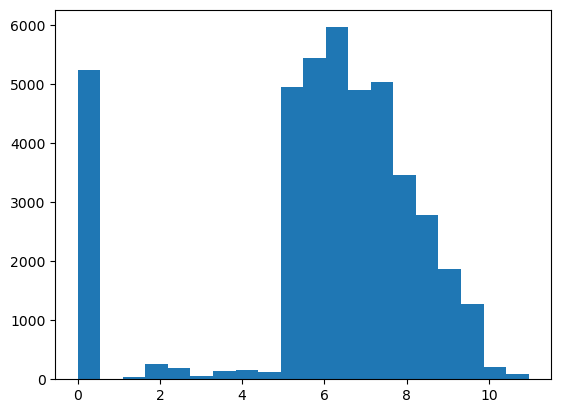

In [14]:
plt.hist(pred, bins=20)
plt.show()

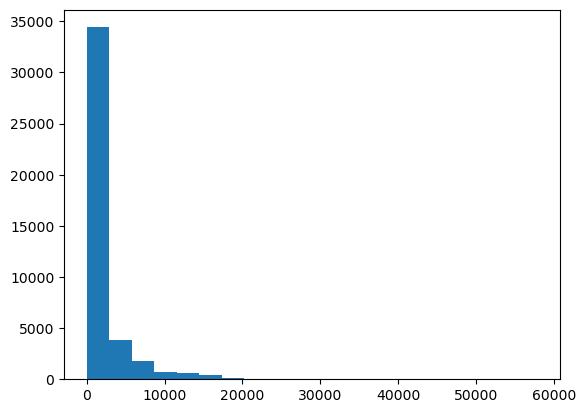

In [15]:
plt.hist(np.exp(pred) - 1, bins=20)
plt.show()

In [16]:
val_df = pd.read_csv('./data/InsNova_data_2023_vh.csv')
ids = val_df['id']
val_df.drop(['id'], axis=1, inplace=True)
val_df.reset_index(drop=True, inplace=True)

val_df.head()

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind
0,3.40,0.076279,STNWG,2,M,B,4,petrol,174,83,black,S,1,weekday,6pm - 12am,6,648.247594,0
1,2.55,0.093443,STNWG,2,F,A,3,petrol,181,65,yellow,M,0,weekday,12am - 6 am,12,637.752677,0
2,3.04,0.157762,STNWG,2,F,E,4,petrol,136,64,white,S,1,weekday,12pm - 6pm,12,661.483786,0
3,2.05,0.560735,MIBUS,4,M,C,6,dissel,164,82,gray,M,1,weekday,6am - 12pm,12,647.846365,0
4,1.93,0.258275,HBACK,2,M,C,4,dissel,89,48,black,S,0,weekday,6am - 12pm,12,640.257550,0


In [17]:
val_df_dummies = pd.get_dummies(val_df, columns=['veh_body', 'veh_age', 'gender', 'area', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind'])
val_df_dummies = val_df_dummies.rename(columns={'high_education_ind_0': 'high_education_ind_0.0', 'high_education_ind_1': 'high_education_ind_1.0'})

0.0
36312.62442
0.0
231.69981057006783


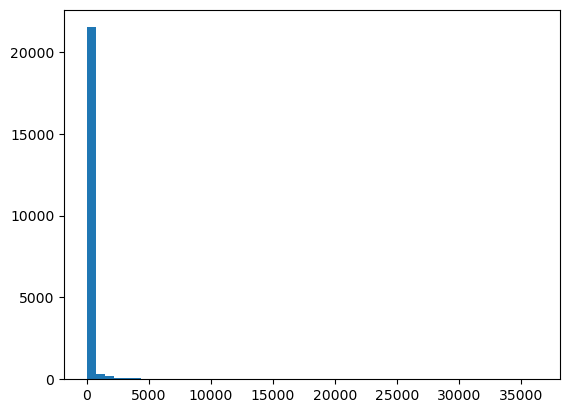

In [18]:
predicted_costs = cost_model.predict(scaler.transform(val_df_dummies))
predicted_costs = np.exp(predicted_costs) - 1

print(predicted_costs.min())
print(predicted_costs.max())
print(np.median(predicted_costs))
print(predicted_costs.mean())

# plt.hist(df['claimcst0'], bins=50)
plt.hist(predicted_costs, bins=50)
plt.show()

In [19]:
submission_df = pd.DataFrame({'id': ids, 'Predict': predicted_costs.reshape(-1,)})
submission_df.head()

,id,Predict
0,1,442.203920
1,2,23.415565
2,3,0.000000
3,4,0.000000
4,5,0.000000


In [20]:
submission_df.to_csv('./data/submission.csv', index=False)